In [1]:
import sqlalchemy
from os import environ

import numpy as np
import pandas as pd

from jupyter_dash import JupyterDash
from dash import html
from dash.dependencies import Input, Output
import plotly.express as px
from dash import dcc

/usr/lib/python3/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## The ESPN fantasy league assigns value to some recorded player statistics. The values include:

- Points scored PTS = 1
- Blocks BLK = 4
- Assists AST = 2
- Rebounds REB = 1
- Field goals made FGM = 2
- Free throws made FTM = 1
- Three pointers made PM3 = 1
- Steals STL = 4

## Some values result in a penalty (negative scores):

- Turnovers TOV = -2
- Field goals attempted FGA = -1
- Free throws attempted FTA = -1

In [2]:
value = {"PTS":1,"BLK":4,"AST":2,"REB":1,"TOV":-2,"FGM":2,"FGA":-1,"FTM":1,"FTA":-1,"PM3":1,"STL":4}

### The fantasy scores are given as :
$$score = \sum^{N-1}_{i=0} v_i \cdot s_i$$

Where $v_i$ is the value assigned to stat $s_i$.

In [3]:
v = np.array(list(value.values()))

In [4]:
stats = ", ".join(list(value.keys()))

In [3]:
engine = sqlalchemy.create_engine("mariadb+mariadbconnector://"+environ.get("USER")+\
                                  ":"+environ.get("PSWD")+"@127.0.0.1:3306/nba")

In [ ]:
csv = pd.read_sql("SELECT * FROM Box_scores INNER JOIN Players on Box_scores.Player_ID = Players.ID ORDER BY Game_day desc",engine,parse_dates=["Game_day"])

In [6]:
fields = "Name, " + stats + ", Game_day "

join =  "Box_scores INNER JOIN Players on Box_scores.Player_ID = Players.ID "

select = "SELECT "+ fields + " FROM " + join + "ORDER BY Game_day desc"

In [7]:
box_scores = pd.read_sql(select,engine,parse_dates=["Game_day"])

In [8]:
box_scores.dtypes
# box_scores["Game_day"] = pd.to_datetime(box_scores["Game_day"])

Name                object
PTS                  int64
BLK                  int64
AST                  int64
REB                  int64
TOV                  int64
FGM                  int64
FGA                  int64
FTM                  int64
FTA                  int64
PM3                  int64
STL                  int64
Game_day    datetime64[ns]
dtype: object

## Calculate the fantasy points by a matrix multiplication
$$\vec{f} = \vec{v} \times \matrix{B} $$

Where $\vec{f}$ is all player's fantasy points, $\vec{v}$ is the values assigned to the all player's box scores $\matrix{B}$.

In [9]:
def calc_fantasy_points(v, box_scores):
    return v @ box_scores

In [10]:
s = np.array(box_scores.values[:,1:-1],dtype = np.int64)

In [11]:
box_scores["Fantasy Points"] = calc_fantasy_points(v, s.T)

## The fantasy scores can then be grouped by the player names and aggregated using a rolling mean on their fantasy scores.

Typically, there are 3-4 games a week and since the Fantasy League is in a week-by week format, it makes sense to set the rolling mean window to 4. This will show how a player is doing on a week to week basis.

In [12]:
names = box_scores["Name"].unique()

In [13]:
rolls= box_scores.sort_values(["Game_day"], ascending=[True]).groupby("Name").rolling(4,min_periods =1).mean()

In [14]:
box_scores["Rolling"] = 1

In [15]:
for i,j in rolls.index:
    box_scores.loc[j,"Rolling"] = rolls.loc[i,j]["Fantasy Points"]

In [16]:
def options(names):
    options = []
    for i in names:
        d = {}
        d["label"] = i
        d["value"] = i
        options.append(d)
        
    return options

## Below defines a dashboard that shows a line graph for aggregated fantasy scores against the game day. A searchable dropdown includes all the players who recorded stats this season. Simply search and select the player(s) of interest and their fantasy points over the course of the season will be visible. The dropdown includes functionality for multiple players to enable multiple comparisons. 

## A second graph, a (overlaid) histogram with the marginal plots for the fantasy points counts is included to show the distribution of fantasy points for the selected players.

In [17]:
def drpdwn(i):
    opts = options(names)
    d = dcc.Dropdown(options = opts, value = names[0:2],id = i,multi = True)
    
    return d

In [18]:
don = box_scores.loc[box_scores['Name'].isin(names[0:2])]

fig = px.line(y="Rolling", x="Game_day",color="Name",data_frame = don, markers=True,range_y=(0,100))
fig.update_layout(title ="Fantasy points during current season", xaxis_title = "Game Day",
                  title_x = 0.5,yaxis_title = "4 game Rolling mean / Fantasy points")

fig2 = px.histogram(don, x= "Fantasy Points",color = "Name",marginal = 'box',barmode='overlay')

app = JupyterDash(__name__)
# colours = {'text': '#7FDBFF', 'background':'#333333','radio_button':'#BBBBBB'} 
# text_size = {'H1':48,'H2':40,'text':28,'radio_button':20}

app.layout = html.Div(className="p-heading",
                      children=[html.H1(children="ESPN Fantasy Analysis"),
                                html.Div(children=[drpdwn('g1'), dcc.Graph(figure = fig, id = 'graph')]),
                                html.Div(children=[dcc.Graph(figure = fig2, id = 'graph2')])
])

@app.callback(
    Output('graph','figure'),
    Output('graph2','figure'),
    Input('g1','value'))
def update_figure(selected):
    d = box_scores.loc[box_scores['Name'].isin(selected)]
    
    fig = px.line(y="Rolling", x="Game_day",color="Name",data_frame = d, markers=True,range_y=(0,100))
    
    fig.update_layout(title ="Fantasy points during current season", xaxis_title = "Game Day",
                  title_x = 0.5,yaxis_title = "4 game Rolling mean / Fantasy points")
    
    fig2 = px.histogram(d, x= "Fantasy Points",color = "Name",marginal = 'box',barmode='overlay')
    return fig,fig2

In [19]:
app.run_server(mode = "external")

Dash app running on http://127.0.0.1:8050/


 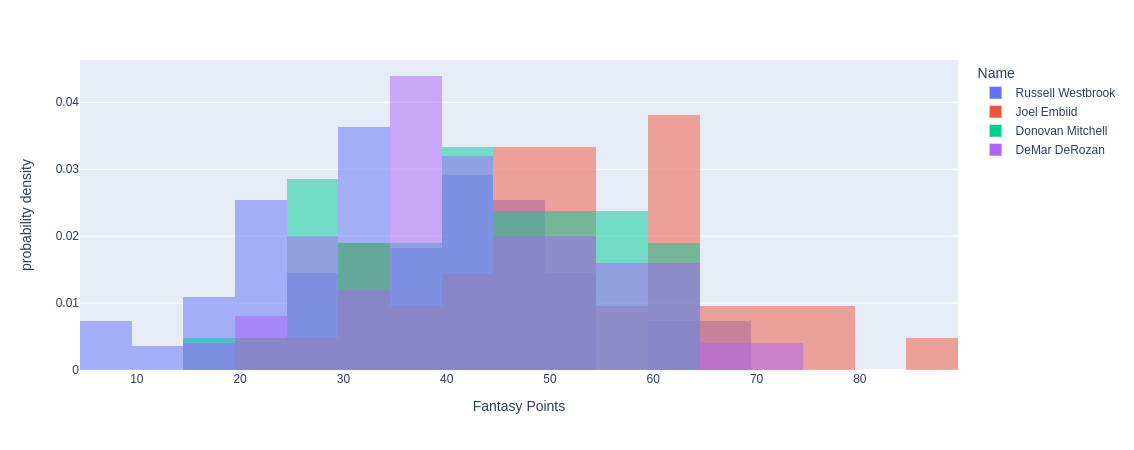
 

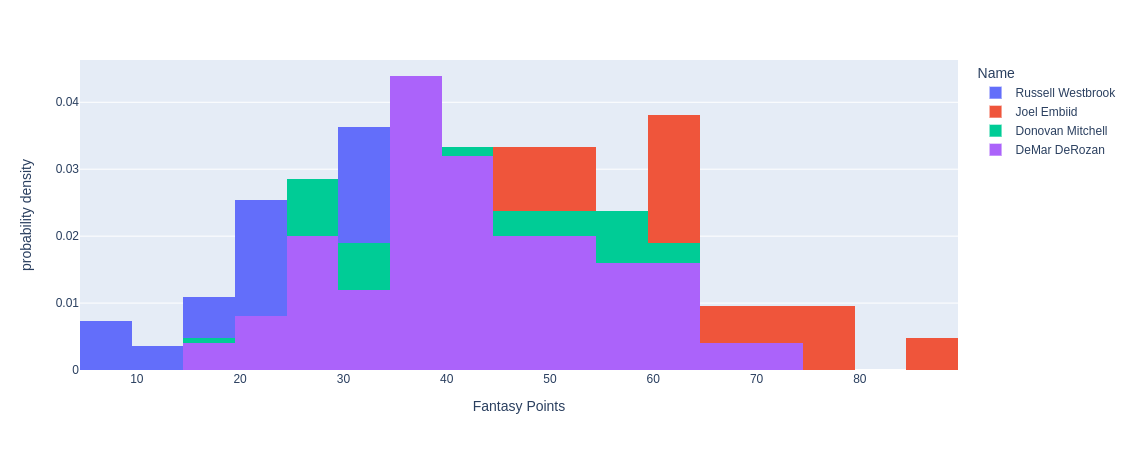

In [20]:
import matplotlib.pyplot as plt

In [21]:
def plot_fp_distribution(fps):
    fig = plt.figure(figsize=(15,2))
    ax = fig.add_axes([0,1,1,1])

    plt.vlines(x = fps, ymin = -0.01,ymax=0.01, colors='b')
    plt.ylim((-0.05,0.05))
    plt.xlim((0,max(fps)+1))
    plt.xlabel("Average Fantasy Points")
    plt.xticks(range(-5,70,5))
    
    return

In [22]:
fps = box_scores.groupby("Name").mean()

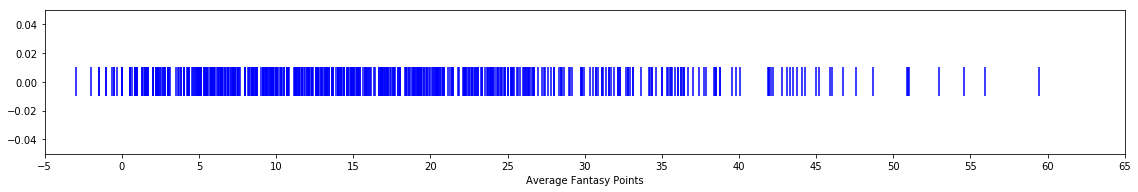

In [23]:
plot_fp_distribution(fps["Fantasy Points"])